## Домашнее задание к вебинару 3

Исходные данные - датасет недвижимости (sklearn.datasets.fetch_california_housing)
   
Задание:
1. Создать Dataset для загрузки данных    
2. Обернуть его в Dataloader     
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости.  Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)  
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели
       
*train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
pip install torchmetrics

     |████████████████████████████████| 398 kB 5.3 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchmetrics

In [3]:
X, y = fetch_california_housing(return_X_y = True)

In [4]:
X = pd.DataFrame(X, columns = fetch_california_housing().feature_names)

In [5]:
X.head(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22


In [6]:

X.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

Пропусков нет

Разделение на тренировочную и тестовую выборки:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 13)

In [8]:
print(f'Train dataset size: {X_train.shape} \nTest dataset size: {X_test.shape}')

Train dataset size: (15480, 8) 
Test dataset size: (5160, 8)


In [9]:
#Обучим стандартизатор

scaler = StandardScaler()
scaler.fit(X_train)

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# X_train = torch.FloatTensor(X_train)
# y_train = torch.FloatTensor(y_train)

# X_train = torch.FloatTensor(X_train)
# y_train = torch.FloatTensor(y_train)

StandardScaler()

### Создание Dataset и оборчивание его в DataLoader

In [10]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, init_X, init_y):
    
        self.init_X = init_X
        self.init_y = init_y

        # Стадартизация
        self.init_X = scaler.transform(self.init_X)

        # Перевод в тензоры
        self.init_X = torch.FloatTensor(self.init_X)
        self.init_y = torch.FloatTensor(self.init_y)
    def __len__(self):
        # return self.init_x.shape[0]
        return len(self.init_X)

    def __getitem__(self, index):
        return self.init_X[index], self.init_y[index]  

In [11]:
train_dataset = CreateDataset(X_train, y_train)

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = 32,
                                               shuffle = True,
                                               num_workers = 2,
                                               drop_last = True)


In [13]:
test_dataset = CreateDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = 12,
                                               shuffle = False,
                                               drop_last = True)

In [14]:
len(test_dataset.__getitem__(3)[0])

8

### Поcтроение нейронной сети

In [15]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation = 'relu'):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
    
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        raise RuntimeError


class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        # Полносвязные слои

        self.bn0 = nn.BatchNorm1d(input_dim)

        # 1 слой
        self.fc1 = Perceptron(input_dim, 4*hidden_dim)
        self.dp1 = nn.Dropout(0.25)
        self.bn1 = nn.BatchNorm1d(4*hidden_dim)

        # 2 слой
        self.fc2 = Perceptron(4*hidden_dim, 2*hidden_dim)
        self.dp2 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(2*hidden_dim)

        # 3 слой
        self.fc3 = Perceptron(2*hidden_dim, hidden_dim)
        self.dp3 = nn.Dropout(0.25)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        # 5 слой
        self.fc4 = Perceptron(hidden_dim, 1)

    def forward(self, x):

        x = self.bn0(x)

        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn1(x)

        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn2(x)

        x = self.fc3(x)
        x = self.dp3(x)
        x = self.bn3(x)

        x = self.fc4(x)
        return x


In [16]:
net = FeedForward(8, 300)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()

Тестовое обучение сети (запустиим сеть для примера)

In [17]:
num_epochs = 10

train_r2 = torchmetrics.R2Score()
test_r2 = torchmetrics.R2Score()

net.train()

for epoch in range(num_epochs):  
    running_loss, running_items = 0.0, 0.0

    for i, data in enumerate(train_dataloader):
        
        inputs, values = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        train_r2(outputs.squeeze(), values)
        loss = criterion(outputs.squeeze(), values)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(values)
  
        
        # выводим статистику о процессе обучения
        if i % 200 == 0:    # печатаем каждые 200 mini-batches
            net.eval()
            print(
                f'Epoch [{epoch + 1}/{num_epochs}]. '\
                f'Step [{i + 1}/{len(train_dataloader)}]. ' \
                f'Loss: {running_loss / running_items:.3f}. ' \
                f'r2_train: {train_r2.compute().item():.3f}, ', end='. ')

                # f'R2: {1 - ((running_loss/running_items)/((values - values.mean())**2).sum()):.3f}', end='. ')
            running_loss, running_items = 0.0, 0.0
            train_r2.reset()
            
            test_loss = 0.0
            for i, data in enumerate(test_dataloader):
           
                test_true_values = data[1]
                test_outputs = net(data[0])
                test_loss += criterion(test_outputs.squeeze(), test_true_values).item()
                test_r2(test_outputs.squeeze(), test_true_values)
            
            print(f'Test loss: {test_loss / len(test_true_values):.3f}. ' \
                  f'r2_val: {test_r2.compute():.3f}')
            test_r2.reset()
            
            

print('Training is finished!')

Epoch [1/10]. Step [1/483]. Loss: 0.127. r2_train: -2.678, . Test loss: 200.345. r2_val: -3.137
Epoch [1/10]. Step [201/483]. Loss: 0.021. r2_train: 0.479, . Test loss: 15.135. r2_val: 0.687
Epoch [1/10]. Step [401/483]. Loss: 0.013. r2_train: 0.685, . Test loss: 14.077. r2_val: 0.709
Epoch [2/10]. Step [1/483]. Loss: 0.017. r2_train: 0.663, . Test loss: 14.576. r2_val: 0.699
Epoch [2/10]. Step [201/483]. Loss: 0.013. r2_train: 0.701, . Test loss: 14.615. r2_val: 0.698
Epoch [2/10]. Step [401/483]. Loss: 0.011. r2_train: 0.732, . Test loss: 14.806. r2_val: 0.694
Epoch [3/10]. Step [1/483]. Loss: 0.013. r2_train: 0.734, . Test loss: 12.246. r2_val: 0.747
Epoch [3/10]. Step [201/483]. Loss: 0.010. r2_train: 0.747, . Test loss: 14.780. r2_val: 0.695
Epoch [3/10]. Step [401/483]. Loss: 0.013. r2_train: 0.679, . Test loss: 13.445. r2_val: 0.722
Epoch [4/10]. Step [1/483]. Loss: 0.013. r2_train: 0.749, . Test loss: 11.986. r2_val: 0.752
Epoch [4/10]. Step [201/483]. Loss: 0.010. r2_train: 0.

### Сравнение сходимости Adam, RMSProp и SGD

In [18]:
# Функция для тренировки сети

def train_evaluation_net(model, optimizer, num_epochs):    
    
    train_r2 = torchmetrics.R2Score()
    test_r2 = torchmetrics.R2Score()
    
    r2_train_list = []
    r2_test_list = []
    
    for epoch in range(num_epochs):
        
        model.train()
        for i, data in enumerate(train_dataloader):
            inputs, target = data[0], data[1] # входные данные с лейблами
            # Обнуляем градиент
            optimizer.zero_grad()
            # Делаем предсказание
            outputs = model(inputs)
            #метрика
            batch_r2 = train_r2(outputs.squeeze(), target)
            # Рассчитываем лосс-функцию (функцию потерь)
            loss = criterion(outputs.squeeze(), target)
            # Вычисляем градиент
            loss.backward()
            # Обновляем веса (делаем шаг оптимайзера)
            optimizer.step()
        
        model.eval()
        for i, data in enumerate(test_dataloader):
            inputs, target = data[0], data[1]
            outputs = model(inputs)
            test_r2(outputs.squeeze(), target)

        # Общий train r2 по всем батчам
        total_train_r2 = train_r2.compute()
        # Общий test r2 по всем батчам
        total_test_r2 = test_r2.compute()
        
        r2_train_list.append(total_train_r2)
        r2_test_list.append(total_test_r2)
        print(f'Epoch {epoch+1}: r2_train = {total_train_r2}, r2_val = {total_test_r2}')

        #reset for next epoch
        train_r2.reset()
        test_r2.reset()

    plt.plot(r2_train_list,label='R2_train', color = 'green')
    plt.plot(r2_test_list,label='R2_test', color = 'blue')

    plt.title(f'R2 score with {str(optimizer).split(" ")[0]} by epochs')
    plt.ylabel('R2_score')   
    plt.xlabel('epochs') 
    plt.legend()
    plt.show()
    
    return r2_train_list, r2_test_list

In [19]:
lr = 0.001

### Adam

Epoch 1: r2_train = 0.31043893098831177, r2_val = 0.3842482566833496
Epoch 2: r2_train = 0.5338366627693176, r2_val = 0.6371292471885681
Epoch 3: r2_train = 0.5888841152191162, r2_val = 0.6639417409896851
Epoch 4: r2_train = 0.6036523580551147, r2_val = 0.639939546585083
Epoch 5: r2_train = 0.6272827386856079, r2_val = 0.6546289324760437
Epoch 6: r2_train = 0.6440117359161377, r2_val = 0.7076253890991211
Epoch 7: r2_train = 0.6540996432304382, r2_val = 0.6846468448638916
Epoch 8: r2_train = 0.6660774946212769, r2_val = 0.6584658622741699
Epoch 9: r2_train = 0.6757571697235107, r2_val = 0.6569647789001465
Epoch 10: r2_train = 0.6799006462097168, r2_val = 0.7280850410461426
Epoch 11: r2_train = 0.6763889789581299, r2_val = 0.6343644857406616
Epoch 12: r2_train = 0.6849367618560791, r2_val = 0.729308545589447


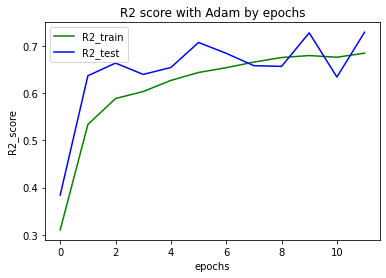

In [23]:
net = FeedForward(8, 300)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
r2_train_list, r2_test_list = train_evaluation_net(net, optimizer, 12)

### SGD

Epoch 1: r2_train = 0.14787817001342773, r2_val = 0.5353310108184814
Epoch 2: r2_train = 0.4776027798652649, r2_val = 0.6418355703353882
Epoch 3: r2_train = 0.6256662607192993, r2_val = 0.6928507089614868
Epoch 4: r2_train = 0.6267226338386536, r2_val = 0.6426570415496826
Epoch 5: r2_train = 0.641450047492981, r2_val = 0.5871254801750183
Epoch 6: r2_train = 0.6473817229270935, r2_val = 0.6262831687927246
Epoch 7: r2_train = 0.6516765356063843, r2_val = 0.6757428050041199
Epoch 8: r2_train = 0.6550889015197754, r2_val = 0.6716107726097107
Epoch 9: r2_train = 0.6600609421730042, r2_val = 0.6186977624893188
Epoch 10: r2_train = 0.6589206457138062, r2_val = 0.7228320837020874
Epoch 11: r2_train = 0.6623678207397461, r2_val = 0.7387346029281616
Epoch 12: r2_train = 0.6665815711021423, r2_val = 0.737203061580658


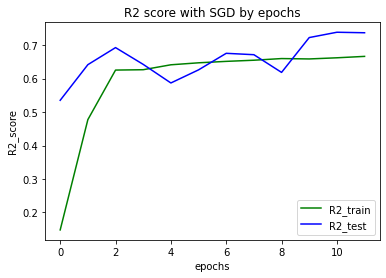

In [21]:
net = FeedForward(8, 300)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum =0.9)
r2_train_list, r2_test_list = train_evaluation_net(net, optimizer, 12)

### RMSprop

Epoch 1: r2_train = 0.35791999101638794, r2_val = 0.5421984195709229
Epoch 2: r2_train = 0.5499981641769409, r2_val = 0.6402336359024048
Epoch 3: r2_train = 0.5865658521652222, r2_val = 0.6011302471160889
Epoch 4: r2_train = 0.6094961166381836, r2_val = 0.6988927125930786
Epoch 5: r2_train = 0.6260003447532654, r2_val = 0.6515076756477356
Epoch 6: r2_train = 0.6427140831947327, r2_val = 0.5866389274597168
Epoch 7: r2_train = 0.644845187664032, r2_val = 0.5928153991699219
Epoch 8: r2_train = 0.6498227119445801, r2_val = 0.38912296295166016
Epoch 9: r2_train = 0.6712137460708618, r2_val = 0.665617823600769
Epoch 10: r2_train = 0.6753650903701782, r2_val = 0.5792835354804993
Epoch 11: r2_train = 0.6773927211761475, r2_val = 0.6310274600982666
Epoch 12: r2_train = 0.6844010353088379, r2_val = 0.7191394567489624


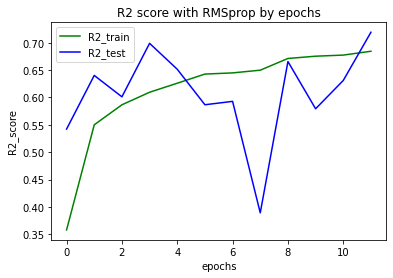

In [27]:
net = FeedForward(8, 300)
optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
r2_train_list, r2_test_list = train_evaluation_net(net, optimizer, 12)

Epoch 1: r2_train = 0.37298399209976196, r2_val = 0.6086758375167847
Epoch 2: r2_train = 0.5710225105285645, r2_val = 0.5527094602584839
Epoch 3: r2_train = 0.5910470485687256, r2_val = 0.6852231025695801
Epoch 4: r2_train = 0.6132402420043945, r2_val = 0.6129491329193115
Epoch 5: r2_train = 0.6374365091323853, r2_val = 0.7219421863555908
Epoch 6: r2_train = 0.6513657569885254, r2_val = 0.7169240713119507
Epoch 7: r2_train = 0.6408841609954834, r2_val = 0.6923370957374573
Epoch 8: r2_train = 0.6518065929412842, r2_val = 0.7350881099700928
Epoch 9: r2_train = 0.6686909198760986, r2_val = 0.7126224040985107
Epoch 10: r2_train = 0.6711776852607727, r2_val = 0.7369186878204346
Epoch 11: r2_train = 0.6860902905464172, r2_val = 0.6424620151519775
Epoch 12: r2_train = 0.6836012601852417, r2_val = 0.7030535936355591


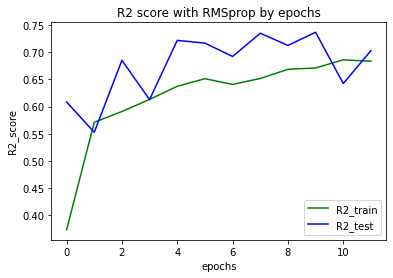

In [40]:
net = FeedForward(8, 300)
optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
r2_train_list, r2_test_list = train_evaluation_net(net, optimizer, 12)

Epoch 1: r2_train = 0.32539474964141846, r2_val = 0.5611470937728882
Epoch 2: r2_train = 0.5153038501739502, r2_val = 0.6667014956474304
Epoch 3: r2_train = 0.5692684650421143, r2_val = 0.6499766707420349
Epoch 4: r2_train = 0.5998649597167969, r2_val = 0.6906926035881042
Epoch 5: r2_train = 0.6143993735313416, r2_val = 0.6833257079124451
Epoch 6: r2_train = 0.6396975517272949, r2_val = 0.6904148459434509
Epoch 7: r2_train = 0.653110146522522, r2_val = 0.6338064670562744
Epoch 8: r2_train = 0.6670893430709839, r2_val = 0.7352559566497803
Epoch 9: r2_train = 0.6716587543487549, r2_val = 0.6372586488723755
Epoch 10: r2_train = 0.6775051355361938, r2_val = 0.6608680486679077
Epoch 11: r2_train = 0.685413658618927, r2_val = 0.7156723737716675
Epoch 12: r2_train = 0.6875231862068176, r2_val = 0.6656528115272522


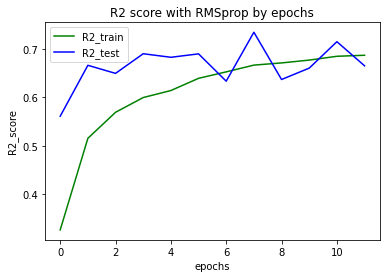

In [39]:
net = FeedForward(8, 300)
optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
r2_train_list, r2_test_list = train_evaluation_net(net, optimizer, 12)

**Вывод:**  
В целом все оптимизаторы показывают себя хорошо и стабильно, наилучшие результаты показал, как ни странно, **SGD**, однако его преимущество перед другими оптимизаторами минимально